# Conditional GAN (cGAN) on MNIST

In the previous notebook (12c), we explored **GANs** that generate images from random noise.

Conditional GANs (cGANs) extend this idea:

- Generator and Discriminator are **conditioned on labels** (e.g., digits 0–9)
- Allows controlled generation:
    - “Generate a 3” or “Generate a 7”
- Training follows the same adversarial min-max setup:
    - Generator tries to fool Discriminator
    - Discriminator distinguishes real from fake, **given the label**

This notebook demonstrates a **simplified, CPU-friendly cGAN** trained on MNIST.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)

# Load MNIST Dataset

(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to [-1,1] for tanh activation
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)

# Convert labels to one-hot vectors
num_classes = 10
y_train_onehot = to_categorical(y_train, num_classes)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot))\
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


TensorFlow version: 2.9.1


In [8]:
# Build Conditional Generator

def make_generator_model():
    noise_dim = 100
    label_dim = num_classes
    
    noise_input = layers.Input(shape=(noise_dim,))
    label_input = layers.Input(shape=(label_dim,))
    
    # Concatenate noise + label
    x = layers.Concatenate()([noise_input, label_input])
    
    # Dense layer on concatenated input
    x = layers.Dense(7*7*128)(x)               # <-- use x here
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7,7,128))(x)
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh')(x)
    
    return tf.keras.Model([noise_input, label_input], x)

# Build Conditional Discriminator

def make_discriminator_model():
    image_input = layers.Input(shape=(28,28,1))
    label_input = layers.Input(shape=(num_classes,))
    
    # Expand label to image dimensions
    label_expanded = layers.Dense(28*28)(label_input)
    label_expanded = layers.Reshape((28,28,1))(label_expanded)
    
    # Concatenate image + label
    x = layers.Concatenate()([image_input, label_expanded])
    
    x = layers.Conv2D(64,5,strides=2,padding='same')(x)
    x = layers.LeakyReLU()(x)      # <-- apply to x
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128,5,strides=2,padding='same')(x)
    x = layers.LeakyReLU()(x)      # <-- apply to x
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    return tf.keras.Model([image_input, label_input], x)

generator = make_generator_model()
discriminator = make_discriminator_model()


In [9]:
# Loss & Optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)


Epoch 1, Gen Loss: 2.6525, Disc Loss: 0.6172


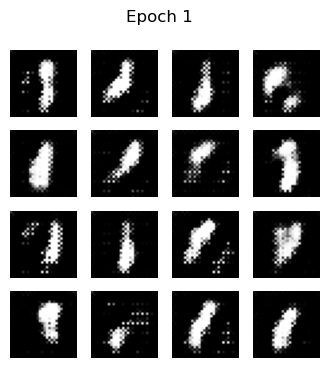

Epoch 2, Gen Loss: 2.2818, Disc Loss: 0.7953


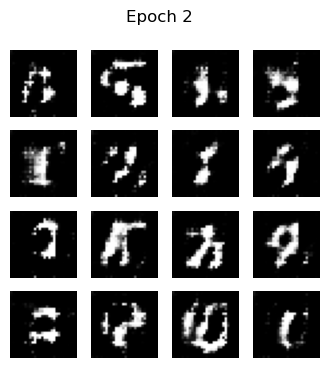

Epoch 3, Gen Loss: 0.8539, Disc Loss: 1.4385


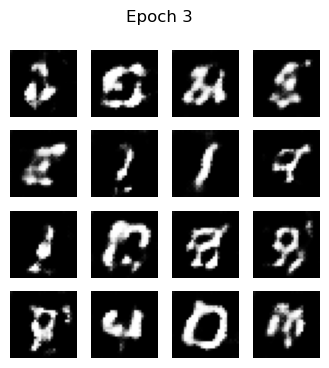

Epoch 4, Gen Loss: 1.3583, Disc Loss: 1.4007


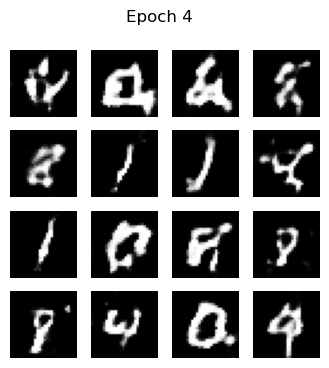

Epoch 5, Gen Loss: 1.2336, Disc Loss: 1.6781


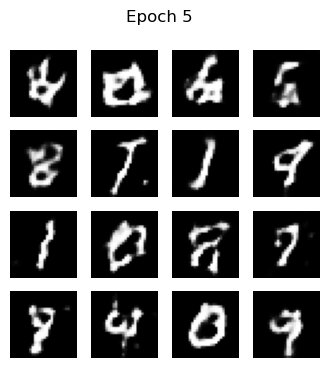

Epoch 6, Gen Loss: 1.0699, Disc Loss: 1.5869


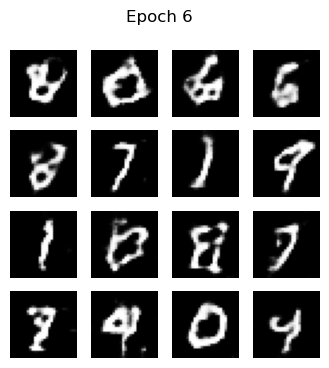

Epoch 7, Gen Loss: 1.2390, Disc Loss: 1.5333


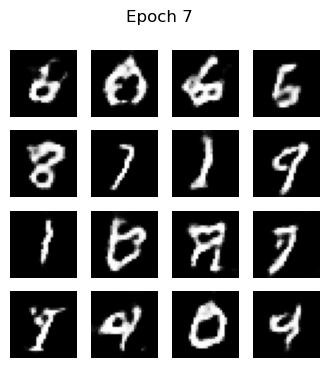

Epoch 8, Gen Loss: 0.9497, Disc Loss: 1.7757


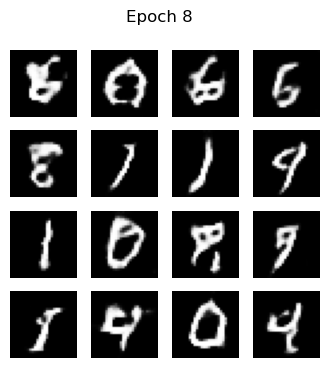

Epoch 9, Gen Loss: 1.1982, Disc Loss: 1.6067


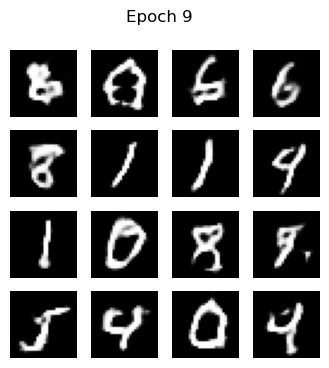

Epoch 10, Gen Loss: 1.2702, Disc Loss: 1.6220


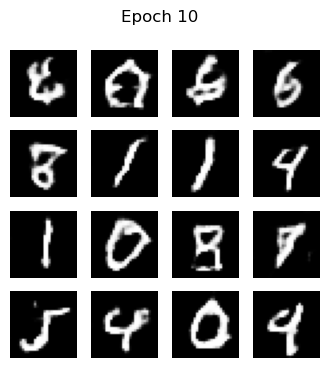

In [10]:
# Training Loop

EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# Fixed seed for visualization
seed_noise = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = to_categorical(np.random.randint(0,num_classes,num_examples_to_generate), num_classes)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    random_labels = tf.one_hot(np.random.randint(0,num_classes,BATCH_SIZE), num_classes)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, random_labels], training=True)
        
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, random_labels], training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, label_batch)
        print(f"Epoch {epoch+1}, Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}")
        generate_and_save_images(generator, epoch+1, seed_noise, seed_labels)

def generate_and_save_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,0]+1)/2, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

train(train_dataset, EPOCHS)


In [14]:
# Visualizing the Conditional GAN Models

# Generator summary
print("Generator Model:")
generator.summary()

# Discriminator summary
print("\nDiscriminator Model:")
discriminator.summary()


Generator Model:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 110)          0           ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 dense_7 (Dense)                (None, 6272)         696192      ['concaten